Before starting, you will need to install some packages to reproduce the baseline.

In [1]:
!pip install tqdm
!pip install scikit-learn

In [2]:
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import optuna
from sklearn.model_selection import StratifiedKFold

# Data architecture

After downloading or unzipping the downloaded files, your data tree must have the following architecture in order to properly run the notebook:
```
your_data_dir/
├── train_output.csv
├── train_input/
│   ├── images/
│       ├── ID_001/
│           ├── ID_001_tile_000_17_170_43.jpg
...
│   └── moco_features/
│       ├── ID_001.npy
...
├── test_input/
│   ├── images/
│       ├── ID_003/
│           ├── ID_003_tile_000_16_114_93.jpg
...
│   └── moco_features/
│       ├── ID_003.npy
...
├── supplementary_data/
│   ├── baseline.ipynb
│   ├── test_metadata.csv
│   └── train_metadata.csv
```

For instance, `your_data_dir = /storage/DATA_CHALLENGE_ENS_2022/`


This notebook aims to reproduce the baseline method on this challenge called `MeanPool`. This method consists in a logistic regression learnt on top of tile-level MoCo V2 features averaged over the slides.

For a given slide $s$ with $N_s=1000$ tiles and corresponding MoCo V2 features $\mathbf{K_s} \in \mathbb{R}^{(1000,\,2048)}$, a slide-level average is performed over the tile axis.

For $j=1,...,2048$:

$$\overline{\mathbf{k_s}}(j) = \frac{1}{N_s} \sum_{i=1}^{N_s} \mathbf{K_s}(i, j) $$

Thus, the training input data for MeanPool consists of $S_{\text{train}}=344$ mean feature vectors $\mathbf{k_s}$, $s=1,...,S_{\text{train}}$, where $S_{\text{train}}$ denotes the number of training samples.

## Data loading

In [3]:
# put your own path to the data root directory (see example in `Data architecture` section)
data_dir = Path("Data")

# load the training and testing data sets
train_features_dir = data_dir / "train_input" / "moco_features"
test_features_dir = data_dir / "test_input" / "moco_features"
df_train = pd.read_csv(data_dir  / "supplementary_data" / "train_metadata.csv")
df_test = pd.read_csv(data_dir  / "supplementary_data" / "test_metadata.csv")

# concatenate y_train and df_train
y_train = pd.read_csv(data_dir  / "train_output.csv")
df_train = df_train.merge(y_train, on="Sample ID")

print(f"Training data dimensions: {df_train.shape}")  # (344, 4)
df_train.head()

Training data dimensions: (344, 4)


,Sample ID,Patient ID,Center ID,Target
0,ID_001.npy,P_001,C_1,0
1,ID_002.npy,P_002,C_2,1
2,ID_005.npy,P_005,C_5,0
3,ID_006.npy,P_006,C_5,0
4,ID_007.npy,P_007,C_2,1


## Data processing

We now load the features matrices $\mathbf{K_s} \in \mathbb{R}^{(1000,\,2048)}$ for $s=1,...,344$ and perform slide-level averaging. This operation should take at most 5 minutes on your laptop.

In [4]:
X_train = []
y_train = []
centers_train = []
patients_train = []

for sample, label, center, patient in tqdm(
    df_train[["Sample ID", "Target", "Center ID", "Patient ID"]].values
):
    # load the coordinates and features (1000, 3+2048)
    _features = np.load(train_features_dir / sample)
    # get coordinates (zoom level, tile x-coord on the slide, tile y-coord on the slide)
    # and the MoCo V2 features
    coordinates, features = _features[:, :3], _features[:, 3:]  # Ks
    # slide-level averaging
    X_train.append(np.mean(features, axis=0))
    y_train.append(label)
    centers_train.append(center)
    patients_train.append(patient)

# convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
centers_train = np.array(centers_train)
patients_train = np.array(patients_train)

  0%| | 0/344 [00:00<?, ?it

  8%| | 27/344 [00:00<00:01

 17%|▏| 58/344 [00:00<00:00

 26%|▎| 89/344 [00:00<00:00

 35%|▎| 120/344 [00:00<00:0

 44%|▍| 151/344 [00:00<00:0

 53%|▌| 183/344 [00:00<00:0

 62%|▌| 214/344 [00:00<00:0

 71%|▋| 244/344 [00:00<00:0

 79%|▊| 272/344 [00:00<00:0

 87%|▊| 299/344 [00:01<00:0

 95%|▉| 326/344 [00:01<00:0

100%|█| 344/344 [00:01<00:0

## 5-fold cross validation

In [5]:
# /!\ we perform splits at the patient level so that all samples from the same patient
# are found in the same split

patients_unique = np.unique(patients_train)
y_unique = np.array(
    [np.mean(y_train[patients_train == p]) for p in patients_unique]
)
centers_unique = np.array(
    [centers_train[patients_train == p][0] for p in patients_unique]
)

print(
    "Training set specifications\n"
    "---------------------------\n"
    f"{len(X_train)} unique samples\n"
    f"{len(patients_unique)} unique patients\n"
    f"{len(np.unique(centers_unique))} unique centers"
)

Training set specifications
---------------------------
344 unique samples
305 unique patients
3 unique centers


In [6]:

def objective(trial):
    # Hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 2, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )
    
    aucs = []
    # 5-fold CV (single repeat for speed in optimization)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_idx_, val_idx_ in kfold.split(patients_unique, y_unique):
        train_idx = np.arange(len(X_train))[
            pd.Series(patients_train).isin(patients_unique[train_idx_])
        ]
        val_idx = np.arange(len(X_train))[
            pd.Series(patients_train).isin(patients_unique[val_idx_])
        ]
        
        X_fold_train = X_train[train_idx]
        y_fold_train = y_train[train_idx]
        X_fold_val = X_train[val_idx]
        y_fold_val = y_train[val_idx]
        
        rf.fit(X_fold_train, y_fold_train)
        preds_val = rf.predict_proba(X_fold_val)[:, 1]
        auc = roc_auc_score(y_fold_val, preds_val)
        aucs.append(auc)
        
    return np.mean(aucs)

# Create study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print(f"Best trial: {study.best_trial.value}")
print(f"Best params: {study.best_trial.params}")

# Retrain with best parameters
best_params = study.best_trial.params
lrs = [] # Reuse 'lrs' variable for compatibility with downstream code

print("Retraining with best parameters...")
aucs = []

# We perform 5-fold CV with best params to get 5 models for the ensemble
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx_, val_idx_ in kfold.split(patients_unique, y_unique):
    train_idx = np.arange(len(X_train))[
        pd.Series(patients_train).isin(patients_unique[train_idx_])
    ]
    val_idx = np.arange(len(X_train))[
        pd.Series(patients_train).isin(patients_unique[val_idx_])
    ]
    
    X_fold_train = X_train[train_idx]
    y_fold_train = y_train[train_idx]
    X_fold_val = X_train[val_idx]
    y_fold_val = y_train[val_idx]
    
    rf = RandomForestClassifier(
        **best_params,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_fold_train, y_fold_train)
    
    preds_val = rf.predict_proba(X_fold_val)[:, 1]
    auc = roc_auc_score(y_fold_val, preds_val)
    aucs.append(auc)
    lrs.append(rf)

print(f"Mean AUC with best params: {np.mean(aucs):.3f}")


[I 2026-02-10 17:05:54,990] A new study created in memory with name: no-name-a9e8b25c-3668-47e0-a9db-5ed26a9d1a6d


[I 2026-02-10 17:05:55,285] Trial 0 finished with value: 0.6642625342630275 and parameters: {'n_estimators': 55, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.6642625342630275.


[I 2026-02-10 17:05:56,046] Trial 1 finished with value: 0.6631927731774829 and parameters: {'n_estimators': 200, 'max_depth': 7, 'min_samples_split': 16, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.6642625342630275.


[I 2026-02-10 17:05:56,335] Trial 2 finished with value: 0.649026149509022 and parameters: {'n_estimators': 53, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.6642625342630275.


[I 2026-02-10 17:05:56,701] Trial 3 finished with value: 0.6586768067371782 and parameters: {'n_estimators': 90, 'max_depth': 29, 'min_samples_split': 14, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.6642625342630275.


[I 2026-02-10 17:05:57,178] Trial 4 finished with value: 0.6667136772078941 and parameters: {'n_estimators': 124, 'max_depth': 27, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 4 with value: 0.6667136772078941.


[I 2026-02-10 17:05:57,770] Trial 5 finished with value: 0.6654683864010851 and parameters: {'n_estimators': 171, 'max_depth': 10, 'min_samples_split': 11, 'min_samples_leaf': 9}. Best is trial 4 with value: 0.6667136772078941.


[I 2026-02-10 17:05:58,245] Trial 6 finished with value: 0.6662317374411384 and parameters: {'n_estimators': 128, 'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 4 with value: 0.6667136772078941.


[I 2026-02-10 17:05:58,667] Trial 7 finished with value: 0.6544286402120134 and parameters: {'n_estimators': 80, 'max_depth': 18, 'min_samples_split': 16, 'min_samples_leaf': 1}. Best is trial 4 with value: 0.6667136772078941.


[I 2026-02-10 17:05:59,381] Trial 8 finished with value: 0.6596848573152551 and parameters: {'n_estimators': 169, 'max_depth': 28, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 4 with value: 0.6667136772078941.


[I 2026-02-10 17:05:59,969] Trial 9 finished with value: 0.6596989062107806 and parameters: {'n_estimators': 163, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 4 with value: 0.6667136772078941.


[I 2026-02-10 17:06:00,120] Trial 10 finished with value: 0.6302118851387638 and parameters: {'n_estimators': 10, 'max_depth': 12, 'min_samples_split': 20, 'min_samples_leaf': 4}. Best is trial 4 with value: 0.6667136772078941.


[I 2026-02-10 17:06:00,621] Trial 11 finished with value: 0.6673505960035836 and parameters: {'n_estimators': 129, 'max_depth': 23, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 11 with value: 0.6673505960035836.


[I 2026-02-10 17:06:01,153] Trial 12 finished with value: 0.6636018949661704 and parameters: {'n_estimators': 127, 'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 11 with value: 0.6673505960035836.


[I 2026-02-10 17:06:01,640] Trial 13 finished with value: 0.6719803447160473 and parameters: {'n_estimators': 121, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 13 with value: 0.6719803447160473.


[I 2026-02-10 17:06:02,100] Trial 14 finished with value: 0.6692608275702803 and parameters: {'n_estimators': 106, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 13 with value: 0.6719803447160473.


[I 2026-02-10 17:06:02,541] Trial 15 finished with value: 0.6656355414707039 and parameters: {'n_estimators': 106, 'max_depth': 30, 'min_samples_split': 12, 'min_samples_leaf': 4}. Best is trial 13 with value: 0.6719803447160473.


[I 2026-02-10 17:06:02,894] Trial 16 finished with value: 0.6526980565311968 and parameters: {'n_estimators': 76, 'max_depth': 13, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 13 with value: 0.6719803447160473.


[I 2026-02-10 17:06:03,314] Trial 17 finished with value: 0.644214352675967 and parameters: {'n_estimators': 146, 'max_depth': 2, 'min_samples_split': 12, 'min_samples_leaf': 5}. Best is trial 13 with value: 0.6719803447160473.


[I 2026-02-10 17:06:03,745] Trial 18 finished with value: 0.6570616447488874 and parameters: {'n_estimators': 96, 'max_depth': 27, 'min_samples_split': 14, 'min_samples_leaf': 3}. Best is trial 13 with value: 0.6719803447160473.


[I 2026-02-10 17:06:04,040] Trial 19 finished with value: 0.6606479578168153 and parameters: {'n_estimators': 60, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 13 with value: 0.6719803447160473.


Best trial: 0.6719803447160473
Best params: {'n_estimators': 121, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 5}
Retraining with best parameters...


Mean AUC with best params: 0.672


# Submission

Now we evaluate the previous models trained through cross-validation so that to produce a submission file that can directly be uploaded on the data challenge platform.

## Data processing

In [7]:
X_test = []

# load the data from `df_test` (~ 1 minute)
for sample in tqdm(df_test["Sample ID"].values):
    _features = np.load(test_features_dir / sample)
    coordinates, features = _features[:, :3], _features[:, 3:]
    X_test.append(np.mean(features, axis=0))

X_test = np.array(X_test)

  0%| | 0/149 [00:00<?, ?it

 22%|▏| 33/149 [00:00<00:00

 45%|▍| 67/149 [00:00<00:00

 67%|▋| 100/149 [00:00<00:0

 89%|▉| 133/149 [00:00<00:0

100%|█| 149/149 [00:00<00:0

## Inference

In [8]:
preds_test = 0
# loop over the classifiers
for lr in lrs:
    preds_test += lr.predict_proba(X_test)[:, 1]
# and take the average (ensembling technique)
preds_test = preds_test / len(lrs)

## Saving predictions

In [9]:
submission = pd.DataFrame(
    {"Sample ID": df_test["Sample ID"].values, "Target": preds_test}
).sort_values(
    "Sample ID"
)  # extra step to sort the sample IDs

# sanity checks
assert all(submission["Target"].between(0, 1)), "`Target` values must be in [0, 1]"
assert submission.shape == (149, 2), "Your submission file must be of shape (149, 2)"
assert list(submission.columns) == [
    "Sample ID",
    "Target",
], "Your submission file must have columns `Sample ID` and `Target`"

# save the submission as a csv file
submission.to_csv(data_dir / "rf_optimized_optuna.csv", index=None)
submission.head()

,Sample ID,Target
0,ID_003.npy,0.482325
1,ID_004.npy,0.447183
2,ID_008.npy,0.444346
3,ID_009.npy,0.409080
4,ID_010.npy,0.307565


# Dealing with images

The following code aims to load and manipulate the images provided as part of  this challenge.

## Scanning images paths on disk

This operation can take up to 5 minutes.

In [10]:
train_images_dir = data_dir / "train_input" / "images"
train_images_files = list(train_images_dir.rglob("*.jpg"))

test_images_dir = data_dir / "test_input" / "images"
test_images_files = list(test_images_dir.rglob("*.jpg"))

print(
    f"Number of images\n"
    "-----------------\n"
    f"Train: {len(train_images_files)}\n" # 344 x 1000 = 344,000 tiles
    f"Test: {len(test_images_files)}\n"  # 149 x 1000 = 149,000 tiles
    f"Total: {len(train_images_files) + len(test_images_files)}\n"  # 493 x 1000 = 493,000 tiles
)

Number of images
-----------------
Train: 344000
Test: 149000
Total: 493000



## Reading

Now we can load some of the `.jpg` images for a given sample, say `ID_001`.

In [11]:
ID_001_tiles = [p for p in train_images_files if 'ID_001' in p.name]

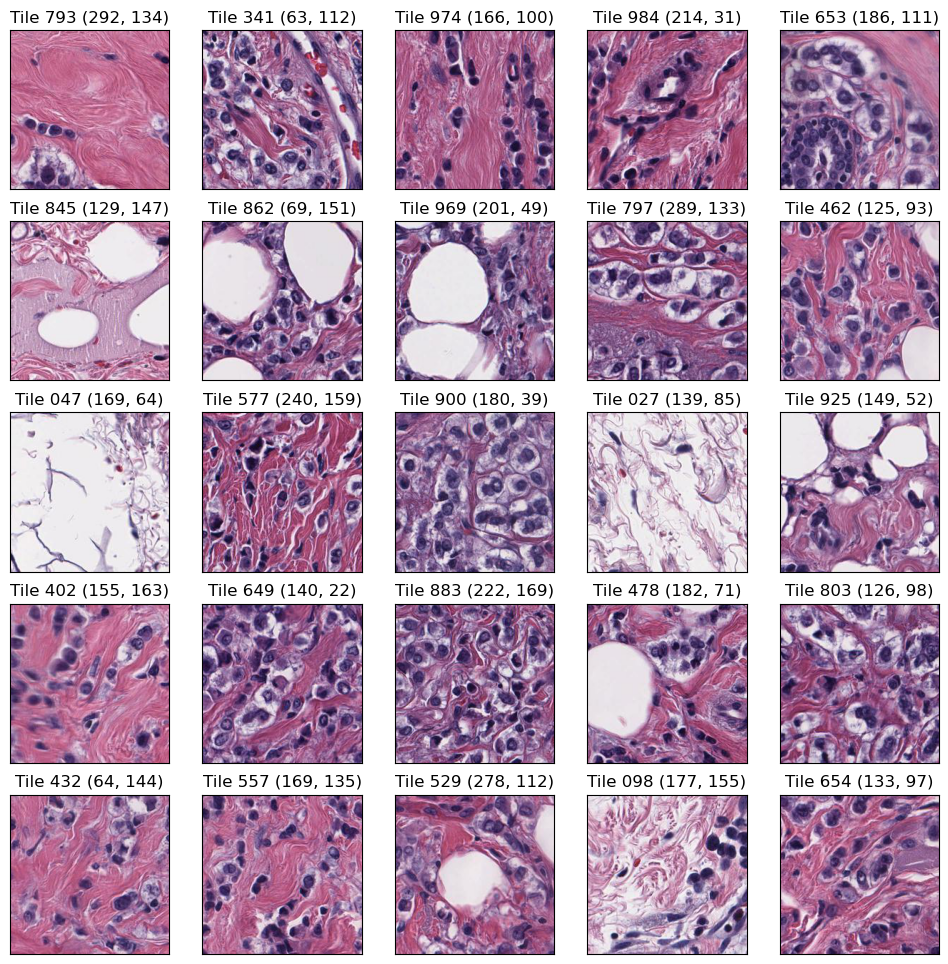

In [12]:
fig, axes = plt.subplots(5, 5)
fig.set_size_inches(12, 12)

for i, img_file in enumerate(ID_001_tiles[:25]):
    # get the metadata from the file path
    _, metadata = str(img_file).split("tile_")
    id_tile, level, x, y = metadata[:-4].split("_")
    img = plt.imread(img_file)
    ax = axes[i//5, i%5]
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Tile {id_tile} ({x}, {y})")
plt.show()

## Mapping with features

Note that the coordinates in the features matrices and tiles number are aligned.

In [13]:
sample = "ID_001.npy"
_features = np.load(train_features_dir / sample)
coordinates, features = _features[:, :3], _features[:, 3:]
print("xy features coordinates")
coordinates[:10, 1:].astype(int)

xy features coordinates


array([[170,  43],
       [245,  49],
       [137, 128],
       [218,  40],
       [142, 117],
       [129,  72],
       [129,  88],
       [164, 109],
       [210,  39],
       [222, 100]])

In [14]:
print(
    "Tiles numbering and features coordinates\n"
)
[tile.name for tile in ID_001_tiles[:10]]

Tiles numbering and features coordinates



['ID_001_tile_793_17_292_134.jpg',
 'ID_001_tile_341_17_63_112.jpg',
 'ID_001_tile_974_17_166_100.jpg',
 'ID_001_tile_984_17_214_31.jpg',
 'ID_001_tile_653_17_186_111.jpg',
 'ID_001_tile_845_17_129_147.jpg',
 'ID_001_tile_862_17_69_151.jpg',
 'ID_001_tile_969_17_201_49.jpg',
 'ID_001_tile_797_17_289_133.jpg',
 'ID_001_tile_462_17_125_93.jpg']